In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelBinarizer

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


In [2]:
import kagglehub
imrandude_olivetti_path = kagglehub.dataset_download('imrandude/olivetti')

print('Data source import complete.')

100%|██████████| 1.81M/1.81M [00:01<00:00, 1.67MB/s]

Extracting files...
Data source import complete.


In [7]:
#loading the ds
from sklearn.datasets import fetch_olivetti_faces

# Load the data
data = fetch_olivetti_faces(shuffle=True, random_state=42)
X = data.data               # shape: (400, 4096)
y = data.target             # shape: (400,)


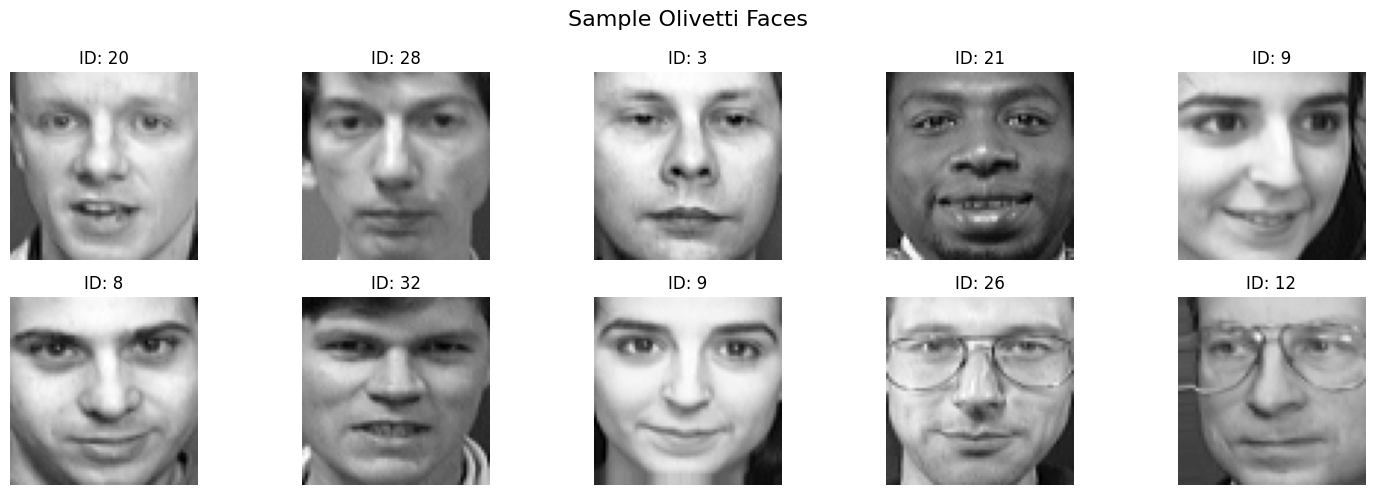

In [12]:
#visualize sample images
# How many faces to show
n_faces = 10

# Set up the figure
plt.figure(figsize=(15, 5))

for i in range(n_faces):
    plt.subplot(2, 5, i + 1)  # 2 rows, 5 columns
    plt.imshow(X[i].reshape(64, 64), cmap='gray')
    plt.title(f"ID: {y[i]}")
    plt.axis('off')

plt.suptitle("Sample Olivetti Faces", fontsize=16)
plt.tight_layout()
plt.show()



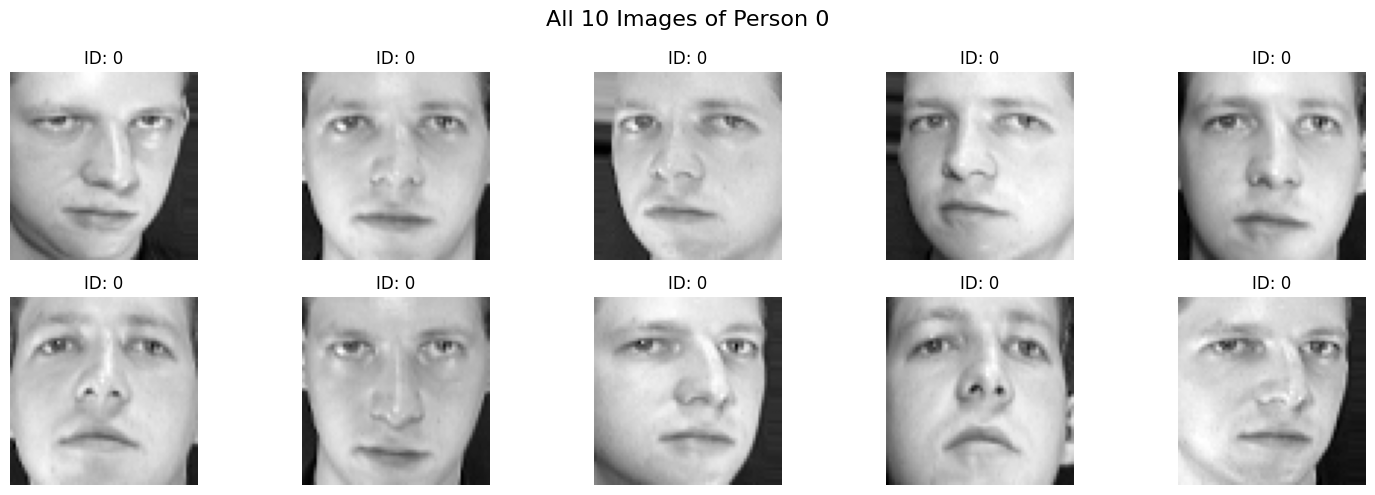

In [15]:
#visualize one person images

# Choose a person ID
person_id = 0

# Get indices of images for the chosen person
indices = np.where(y == person_id)[0]

# Set up the figure to display 10 images
plt.figure(figsize=(15, 5))

for i, idx in enumerate(indices):
    plt.subplot(2, 5, i + 1)  # 2 rows, 5 columns
    plt.imshow(X[idx].reshape(64, 64), cmap='gray')
    plt.title(f"ID: {y[idx]}")
    plt.axis('off')

plt.suptitle(f"All 10 Images of Person {person_id}", fontsize=16)
plt.tight_layout()
plt.show()


In [16]:
#PCA for Dimensionality Reduction
from sklearn.decomposition import PCA

pca = PCA(n_components=150, whiten=True, random_state=42)
X_pca = pca.fit_transform(X)


In [17]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

X_train, X_test, y_train, y_test = train_test_split(X_pca, y, stratify=y, test_size=0.2, random_state=42)

# One-hot encode labels
encoder = LabelBinarizer()
y_train_enc = encoder.fit_transform(y_train)
y_test_enc = encoder.transform(y_test)


In [27]:
#define and train MLP
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_pca.shape[1],)),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(40, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train_enc, epochs=100, batch_size=16,
                    validation_split=0.2, callbacks=[early_stop])


Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.0223 - loss: 4.0378 - val_accuracy: 0.0312 - val_loss: 3.6859
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.1178 - loss: 3.5692 - val_accuracy: 0.0781 - val_loss: 3.5954
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1189 - loss: 3.2652 - val_accuracy: 0.1406 - val_loss: 3.5117
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1822 - loss: 2.9828 - val_accuracy: 0.1875 - val_loss: 3.3780
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3249 - loss: 2.6485 - val_accuracy: 0.2812 - val_loss: 3.2621
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4746 - loss: 2.3199 - val_accuracy: 0.4062 - val_loss: 3.0985
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5281 - loss: 2.0512 - val_accuracy: 0.4219 - val_loss: 2.8874
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6802 - loss: 1.5815 - val_accuracy: 0.5000 -

In [30]:
#evaluation
test_loss, test_acc = model.evaluate(X_test, y_test_enc)
print(f"Test Accuracy: {test_acc:.4f}")


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8391 - loss: 0.6173
Test Accuracy: 0.8500


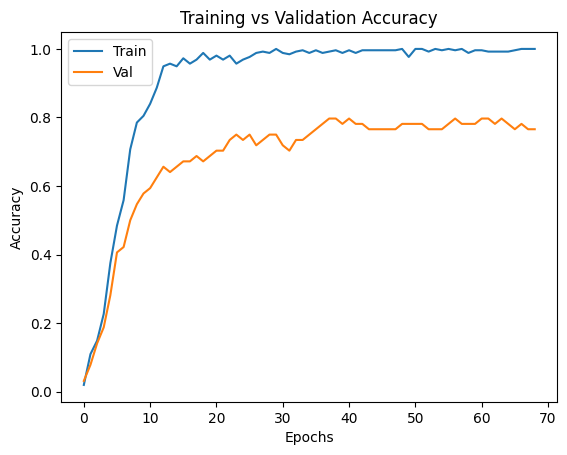

In [31]:
#accuracy curve
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.show()


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


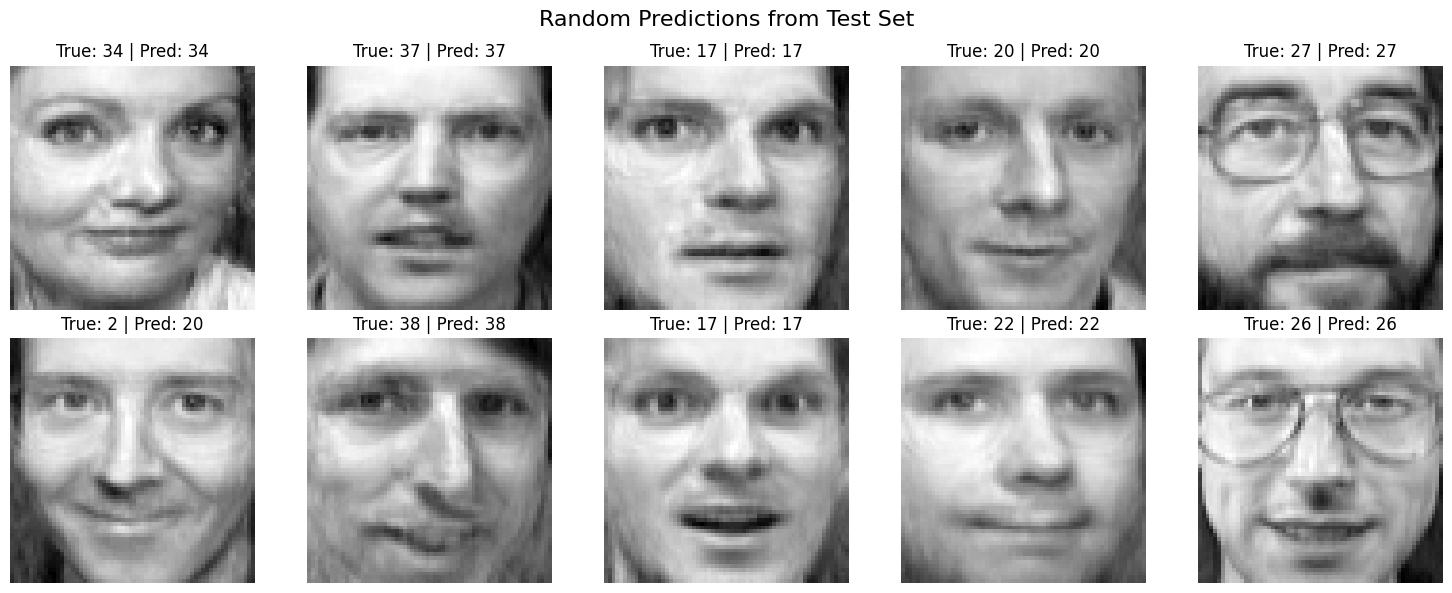

In [36]:
#predicition on the test data

# Get 10 random indices from the test set
random_indices = np.random.choice(X_test.shape[0], size=10, replace=False)

# Predict on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Set up the figure to display 10 images
plt.figure(figsize=(15, 6))

for i, idx in enumerate(random_indices):
    img = pca.inverse_transform(X_test[idx]).reshape(64, 64)
    plt.subplot(2, 5, i + 1)  # 2 rows, 5 columns
    plt.imshow(img, cmap='gray')
    plt.title(f"True: {y_test[idx]} | Pred: {y_pred_classes[idx]}")
    plt.axis('off')

plt.suptitle("Random Predictions from Test Set", fontsize=16)
plt.tight_layout()
plt.show()
